In [1]:
import os
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jre1.8.0_461"
os.environ["HADOOP_HOME"] = "C:/hadoop"

import sparknlp
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("SparkNLP")
         .config("spark.driver.memory", "8G")
         .config("spark.kryoserializer.buffer.max", "2000M")
         .config("spark.hadoop.native.io.enabled", "false")
         .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:6.2.2")
         .getOrCreate())
spark = sparknlp.start()
print("Spark NLP:", sparknlp.version())

Spark NLP: 6.2.2


In [2]:
# Load dataset
df = spark.read.csv(
    "scraped/.ipynb_checkpoints/steam_reviews.csv",
    header=True,
    inferSchema=True,
    multiLine=True,
    escape='"'
)

df.printSchema()
df.show(5, truncate=False)

root
 |-- user: long (nullable = true)
 |-- date: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- helpful: integer (nullable = true)
 |-- recommended: string (nullable = true)

+-----------------+---------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
from pyspark.sql.functions import col, count, when

# Total data
df.count()

# Missing value check
df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show()


+----+----+-------+-------+-----------+
|user|date|comment|helpful|recommended|
+----+----+-------+-------+-----------+
|   0|   0|     49|      0|          0|
+----+----+-------+-------+-----------+



In [4]:
from pyspark.sql.functions import when, col

df = df.withColumn(
    "sentiment",
    when(col("recommended") == "Recommended", "positive")
    .otherwise("negative")
)

df.groupBy("sentiment").count().show()


+---------+-----+
|sentiment|count|
+---------+-----+
| positive| 9737|
| negative| 2556|
+---------+-----+



In [5]:
from pyspark.sql.functions import lower, regexp_replace, trim

df_clean = (
    df
    .withColumn("clean_comment", lower(col("comment")))
    .withColumn("clean_comment", regexp_replace("clean_comment", "[^a-z\\s]", ""))
    .withColumn("clean_comment", regexp_replace("clean_comment", "\\s+", " "))
    .withColumn("clean_comment", trim(col("clean_comment")))
)

df_clean.select("clean_comment").show(3, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(
    inputCol="clean_comment",
    outputCol="tokens"
)

df_tokens = tokenizer.transform(df_clean)


In [7]:
from pyspark.sql.functions import explode

words_df = df_tokens.select(
    explode("tokens").alias("word"),
    col("sentiment")
)


In [8]:
pos_words = (
    words_df
    .filter(col("sentiment") == "positive")
    .groupBy("word")
    .count()
    .withColumnRenamed("count", "pos_count")
)

neg_words = (
    words_df
    .filter(col("sentiment") == "negative")
    .groupBy("word")
    .count()
    .withColumnRenamed("count", "neg_count")
)


In [9]:
word_sentiment = (
    pos_words
    .join(neg_words, "word", "outer")
    .na.fill(0)
)


In [10]:
from pyspark.sql.functions import length

df_clean = (
    df
    .withColumn("clean_comment", lower(col("comment")))
    .withColumn("clean_comment", regexp_replace("clean_comment", "[^a-z\\s]", ""))
    .withColumn("clean_comment", regexp_replace("clean_comment", "\\s+", " "))
    .withColumn("clean_comment", trim(col("clean_comment")))
    .filter(col("clean_comment").isNotNull())
    .filter(length(col("clean_comment")) > 0)
)



In [11]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(
    inputCol="clean_comment",
    outputCol="tokens"
)

df_tokens = tokenizer.transform(df_clean)
df_tokens.select("tokens").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
df_clean.selectExpr(
    "count(*) as total",
    "sum(case when clean_comment is null then 1 else 0 end) as null_count",
    "sum(case when clean_comment = '' then 1 else 0 end) as empty_count"
).show()


+-----+----------+-----------+
|total|null_count|empty_count|
+-----+----------+-----------+
|11988|         0|          0|
+-----+----------+-----------+



In [13]:
from pyspark.sql.functions import explode

words_df = (
    df_tokens
    .select(explode("tokens").alias("word"), col("sentiment"))
    .filter(length(col("word")) > 1)   # optional: buang 1 huruf
)


In [14]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered_tokens"
)

df_filtered = remover.transform(df_tokens)
df_filtered.select("filtered_tokens").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
from pyspark.sql.functions import explode, length

words_df = (
    df_filtered
    .select(explode("filtered_tokens").alias("word"), col("sentiment"))
    .filter(length(col("word")) > 2)   # buang kata terlalu pendek
)


In [16]:
pos_words = (
    words_df
    .filter(col("sentiment") == "positive")
    .groupBy("word")
    .count()
    .withColumnRenamed("count", "pos_count")
)

neg_words = (
    words_df
    .filter(col("sentiment") == "negative")
    .groupBy("word")
    .count()
    .withColumnRenamed("count", "neg_count")
)


In [17]:
word_sentiment = (
    pos_words
    .join(neg_words, "word", "outer")
    .na.fill(0)
)


In [18]:
context_count = (
    words_df
    .groupBy("word")
    .count()
    .withColumnRenamed("count", "context_count")
)

final_df = word_sentiment.join(context_count, "word")


In [19]:
total_pos = pos_words.selectExpr("sum(pos_count)").collect()[0][0]
total_neg = neg_words.selectExpr("sum(neg_count)").collect()[0][0]
total_all = total_pos + total_neg


In [20]:
from pyspark.sql.functions import log2

final_df = (
    final_df
    .withColumn("p_w", col("context_count") / total_all)
    .withColumn("p_w_pos", col("pos_count") / total_pos)
    .withColumn("p_w_neg", col("neg_count") / total_neg)
    .withColumn("pmi_positive", log2(col("p_w_pos") / col("p_w")))
    .withColumn("pmi_negative", log2(col("p_w_neg") / col("p_w")))
)


In [21]:
final_df = final_df.withColumn(
    "sentiment_score",
    col("pmi_positive") - col("pmi_negative")
)


In [22]:
final_df = word_sentiment.join(context_count, "word")


In [23]:
final_df.show(10, truncate=False)


+---------+---------+---------+-------------+
|word     |pos_count|neg_count|context_count|
+---------+---------+---------+-------------+
|aaa      |62       |50       |112          |
|aaaa     |1        |8        |9            |
|aaaaaaaa |1        |0        |1            |
|aaaaand  |0        |1        |1            |
|aaah     |0        |1        |1            |
|aaahh    |0        |1        |1            |
|aaayyy   |1        |0        |1            |
|aanrader |1        |0        |1            |
|aatguably|1        |0        |1            |
|abad     |1        |0        |1            |
+---------+---------+---------+-------------+
only showing top 10 rows



In [24]:
from pyspark.sql.functions import length

final_df = final_df.filter(length(col("word")) >= 3)


In [25]:
final_df = final_df.filter(col("context_count") >= 5)


In [26]:
final_df = final_df.filter(
    ~col("word").rlike("^(.)\\1+$")
)


In [27]:
final_df.orderBy(col("context_count").desc()).show(20, truncate=False)


+---------+---------+---------+-------------+
|word     |pos_count|neg_count|context_count|
+---------+---------+---------+-------------+
|game     |11987    |5129     |17116        |
|like     |4042     |1653     |5695         |
|good     |3618     |702      |4320         |
|story    |3089     |1095     |4184         |
|games    |2468     |829      |3297         |
|creed    |2429     |683      |3112         |
|assassins|2325     |697      |3022         |
|really   |2257     |733      |2990         |
|play     |1910     |1066     |2976         |
|one      |2051     |653      |2704         |
|combat   |2017     |628      |2645         |
|fun      |2230     |381      |2611         |
|ubisoft  |1536     |1049     |2585         |
|time     |1536     |859      |2395         |
|great    |2108     |264      |2372         |
|dont     |1586     |781      |2367         |
|get      |1388     |882      |2270         |
|world    |1710     |481      |2191         |
|stealth  |1728     |362      |209

In [28]:
final_df = (
    final_df
    .withColumn("p_w", col("context_count") / total_all)
    .withColumn("p_w_pos", col("pos_count") / total_pos)
    .withColumn("p_w_neg", col("neg_count") / total_neg)
    .withColumn("pmi_positive", log2(col("p_w_pos") / col("p_w")))
    .withColumn("pmi_negative", log2(col("p_w_neg") / col("p_w")))
    .withColumn("sentiment_score", col("pmi_positive") - col("pmi_negative"))
)


In [29]:
final_df = final_df.filter(col("word").rlike("^[a-z]+$"))


In [30]:
final_df.orderBy(col("sentiment_score").desc()).show(15)


+-----------+---------+---------+-------------+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+
|       word|pos_count|neg_count|context_count|                 p_w|             p_w_pos|             p_w_neg|       pmi_positive|       pmi_negative|   sentiment_score|
+-----------+---------+---------+-------------+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+
|       goty|       41|        1|           42|9.207719576707977E-5|1.292303231073273...|7.200668222011003E-6|  0.489028827717391|  -3.67664119653833| 4.165670024255721|
|captivating|       39|        1|           40|8.769256739721884E-5|1.229264049069699...|7.200668222011003E-6| 0.4872683698529532|-3.6062518686469325|4.0935202384998854|
|        und|       36|        1|           37|8.111562484242742E-5|1.134705276064337...|7.200668222011003E-6| 0.4842658816914301|  -3.49377713938852|

In [31]:
final_df = final_df.filter(
    col("word").rlike("^[a-z]{3,}$")  # hanya huruf, min 3 char
)


In [32]:
final_df = final_df.filter(col("context_count") >= 10)


In [33]:
alpha = 1.0
vocab_size = final_df.count()

final_df = (
    final_df
    .withColumn("p_w_pos_smooth",
        (col("pos_count") + alpha) / (total_pos + alpha * vocab_size)
    )
    .withColumn("p_w_neg_smooth",
        (col("neg_count") + alpha) / (total_neg + alpha * vocab_size)
    )
)


In [34]:
final_df = (
    final_df
    .withColumn("pmi_pos_smooth", log2(col("p_w_pos_smooth") / col("p_w")))
    .withColumn("pmi_neg_smooth", log2(col("p_w_neg_smooth") / col("p_w")))
)


In [35]:
from pyspark.sql.functions import log

final_df = final_df.withColumn(
    "sentiment_score_weighted",
    (col("pmi_pos_smooth") - col("pmi_neg_smooth")) * log(col("context_count") + 1)
)


In [36]:
final_df.orderBy(
    col("sentiment_score_weighted").desc()
).show(20, truncate=False)


+----------+---------+---------+-------------+---------------------+---------------------+---------------------+-------------------+-------------------+------------------+---------------------+---------------------+-------------------+-------------------+------------------------+
|word      |pos_count|neg_count|context_count|p_w                  |p_w_pos              |p_w_neg              |pmi_positive       |pmi_negative       |sentiment_score   |p_w_pos_smooth       |p_w_neg_smooth       |pmi_pos_smooth     |pmi_neg_smooth     |sentiment_score_weighted|
+----------+---------+---------+-------------+---------------------+---------------------+---------------------+-------------------+-------------------+------------------+---------------------+---------------------+-------------------+-------------------+------------------------+
|loving    |151      |5        |156          |3.420010128491534E-4 |4.7594582412698613E-4|3.600334111005501E-5 |0.47679676634089807|-3.247797897734456 |3.724

In [37]:
final_df.orderBy(
    col("sentiment_score_weighted").asc()
).show(20, truncate=False)


+----------+---------+---------+-------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+---------------------+---------------------+-------------------+------------------+------------------------+
|word      |pos_count|neg_count|context_count|p_w                  |p_w_pos              |p_w_neg              |pmi_positive       |pmi_negative      |sentiment_score    |p_w_pos_smooth       |p_w_neg_smooth       |pmi_pos_smooth     |pmi_neg_smooth    |sentiment_score_weighted|
+----------+---------+---------+-------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+---------------------+---------------------+-------------------+------------------+------------------------+
|garbage   |15       |86       |101          |2.2142373267797756E-4|4.7279386502680744E-5|6.192574670929463E-4 |-2.2275266412652086|1.4837294981907336|-3.711256

In [38]:
sentiment_words = [
    "good","great","amazing","awesome","excellent","bad","terrible","boring",
    "garbage","worst","fun","enjoyable","love","hate","perfect","flawless",
    "crashing","unplayable","refund","drm","offline"
]

In [39]:
final_df_sentiment = final_df.filter(
    col("word").isin(sentiment_words)
)


In [40]:
from pyspark.sql.functions import abs

final_df = final_df.withColumn(
    "neutrality_penalty",
    1 - (abs(col("pos_count") - col("neg_count")) / col("context_count"))
)


In [41]:
final_df = final_df.withColumn(
    "semantic_sentiment_score",
    col("sentiment_score_weighted") * (1 - col("neutrality_penalty"))
)


In [42]:
final_df.orderBy(
    col("sentiment_score_weighted").desc()
).show(20, truncate=False)

+----------+---------+---------+-------------+---------------------+---------------------+---------------------+-------------------+-------------------+------------------+---------------------+---------------------+-------------------+-------------------+------------------------+-------------------+------------------------+
|word      |pos_count|neg_count|context_count|p_w                  |p_w_pos              |p_w_neg              |pmi_positive       |pmi_negative       |sentiment_score   |p_w_pos_smooth       |p_w_neg_smooth       |pmi_pos_smooth     |pmi_neg_smooth     |sentiment_score_weighted|neutrality_penalty |semantic_sentiment_score|
+----------+---------+---------+-------------+---------------------+---------------------+---------------------+-------------------+-------------------+------------------+---------------------+---------------------+-------------------+-------------------+------------------------+-------------------+------------------------+
|loving    |151      |

In [43]:
final_df.orderBy(
    col("sentiment_score_weighted").asc()
).show(20, truncate=False)


+----------+---------+---------+-------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+---------------------+---------------------+-------------------+------------------+------------------------+-------------------+------------------------+
|word      |pos_count|neg_count|context_count|p_w                  |p_w_pos              |p_w_neg              |pmi_positive       |pmi_negative      |sentiment_score    |p_w_pos_smooth       |p_w_neg_smooth       |pmi_pos_smooth     |pmi_neg_smooth    |sentiment_score_weighted|neutrality_penalty |semantic_sentiment_score|
+----------+---------+---------+-------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+---------------------+---------------------+-------------------+------------------+------------------------+-------------------+------------------------+
|garbage   |15       |86 

In [44]:
from pyspark.sql.functions import col

top_positive_df = (
    final_df
    .orderBy(col("semantic_sentiment_score").desc())
    .select("word", "semantic_sentiment_score")
    .limit(15)
)

top_negative_df = (
    final_df
    .orderBy(col("semantic_sentiment_score").asc())
    .select("word", "semantic_sentiment_score")
    .limit(15)
)


In [45]:
top_positive = top_positive_df.toPandas()
top_negative = top_negative_df.toPandas()


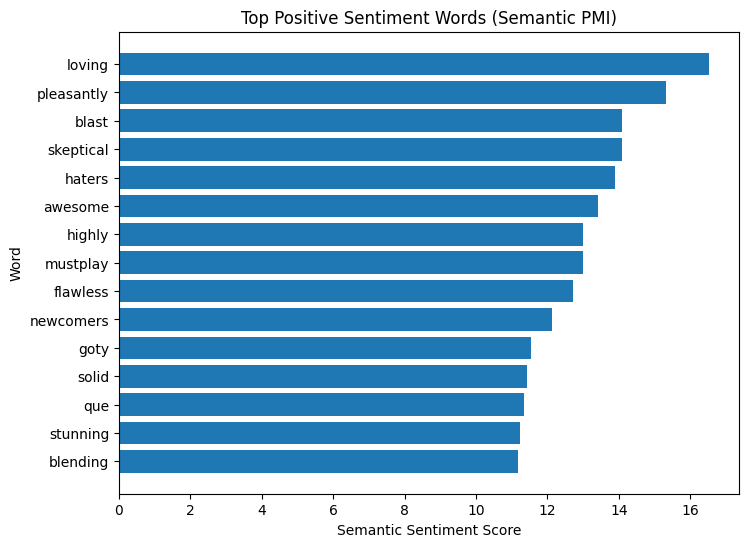

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(top_positive["word"], top_positive["semantic_sentiment_score"])
plt.title("Top Positive Sentiment Words (Semantic PMI)")
plt.xlabel("Semantic Sentiment Score")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.show()


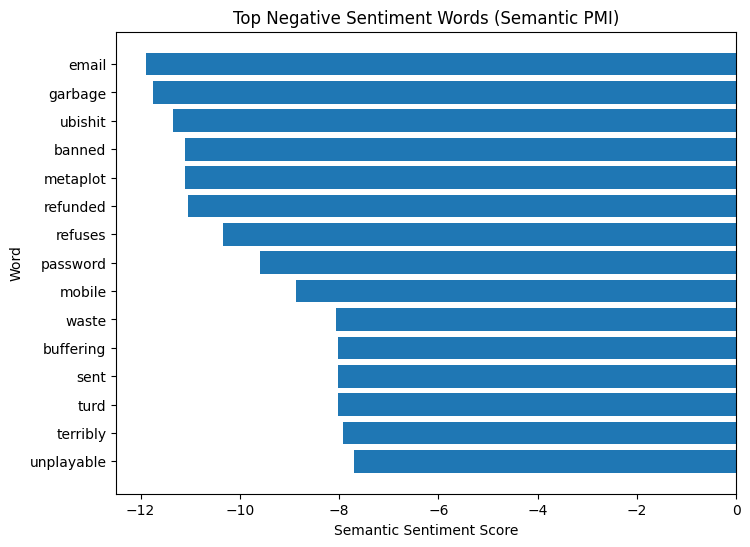

In [47]:
plt.figure(figsize=(8, 6))
plt.barh(top_negative["word"], top_negative["semantic_sentiment_score"])
plt.title("Top Negative Sentiment Words (Semantic PMI)")
plt.xlabel("Semantic Sentiment Score")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.show()


In [49]:
import os, glob, shutil
from pyspark.sql.functions import lit, col
os.makedirs('output', exist_ok=True)
export_df = final_df.select(
    'word',
    'context_count',
    'pos_count',
    'neg_count',
    'pmi_positive',
    'pmi_negative',
    'sentiment_score',
    'sentiment_score_weighted',
    'semantic_sentiment_score',
    'neutrality_penalty'
).withColumn('source', lit('steam'))
tmp_dir = 'output/_steam_sentiment_tmp'
# Write via Spark to a temporary folder then move the single part file to desired CSV
parts = glob.glob(os.path.join(tmp_dir, 'part-*'))
if parts:
    shutil.move(parts[0], os.path.join('output', 'steam_sentiment.csv'))
    # cleanup temporary folder/files
    for f in glob.glob(os.path.join(tmp_dir, '*')):
        try:
            os.remove(f)
        except Exception:
            pass
    shutil.rmtree(tmp_dir, ignore_errors=True)
else:
    # fallback: when data is small, convert to pandas and write directly
    try:
        pdf = export_df.toPandas()
        pdf.to_csv('output/steam_sentiment.csv', index=False)
    except Exception as e:
        print('Failed to write CSV:', e)
